In [38]:
import numpy as np
import tensorflow as tf
import pickle as p
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_DATA")

Extracting MNIST_DATA/train-images-idx3-ubyte.gz
Extracting MNIST_DATA/train-labels-idx1-ubyte.gz
Extracting MNIST_DATA/t10k-images-idx3-ubyte.gz
Extracting MNIST_DATA/t10k-labels-idx1-ubyte.gz


In [40]:
def model_inputs(real_dim,z_dim):
    real_inputs = tf.placeholder(tf.float32,(None,real_dim),name='real_inputs')
    z_inputs = tf.placeholder(tf.float32,(None,z_dim),name='z_inputs')
    return real_inputs,z_inputs

In [41]:
"""generator"""
def generator(z,output_dim,neurons=128,reuse=False,alpha=0.01):
    with tf.variable_scope('generator',reuse=reuse):
        l1 = tf.layers.dense(z,neurons,activation=None)
        #leaky relu
        l1 = tf.maximum(alpha*l1,l1)
        logits = tf.layers.dense(l1,output_dim,activation=None)
        output = tf.nn.tanh(logits)
        return output,logits

In [42]:
"""discriminator"""
def discriminator(input_dim,neurons=128,reuse=False,alpha=0.01):
    with tf.variable_scope('discriminator',reuse=reuse):
        l1 = tf.layers.dense(input_dim,neurons,activation=None)
        #leaky relu
        l1 = tf.maximum(alpha*l1,l1)
        logits = tf.layers.dense(l1,1,activation=None)
        output = tf.nn.sigmoid(logits)
        return output,logits

In [43]:
input_size = 28*28
z_size = 100
alpha = 0.01
g_neurons = 128
d_neurons = 128
label_smoothing = 0.1

In [44]:
"""create graph"""
tf.reset_default_graph()
real_inputs,z_inputs = model_inputs(input_size,z_size)
#generator network
g_output,g_logits = generator(z_inputs,input_size,g_neurons,alpha=alpha)
#real discriminator
d_real_output,d_real_logits = discriminator(real_inputs,d_neurons,alpha=alpha)
#fake discriminator
d_fake_output,d_fake_logits = discriminator(g_output,d_neurons,reuse=True,alpha=alpha)

In [45]:
"""losses"""
d_real_labels = tf.ones_like(d_real_logits)*(1-label_smoothing)
d_fake_labels = tf.zeros_like(d_fake_logits)
d_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_real_labels,logits=d_real_logits)
d_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=d_fake_labels,logits=d_fake_logits)
d_loss = tf.reduce_mean(d_real_loss + d_fake_loss)
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_fake_logits),logits=d_fake_logits))

In [46]:
"""optimizers"""
l_rate = 0.002
var = tf.trainable_variables()
d_vars = [v for v in var if v.name.startswith('discriminator')]
g_vars = [v for v in var if v.name.startswith('generator')]
d_optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(d_loss,var_list=d_vars)
g_optimizer = tf.train.AdamOptimizer(learning_rate=l_rate).minimize(g_loss,var_list=g_vars)

In [47]:
# import cv2
# batch = mnist.train.next_batch(2)
# b = batch[0].reshape((28,28))
# #print(batch[0][0].reshape((28,28)).shape)
# print(b.shape)
# cv2.imshow('image',b)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# a = np.array([[0,0,0,0,0.3],[0,0.2,0.4,0,0]])
# a = a*2-1
# print(a)

In [83]:
"""training"""
epochs = 150
batch_size = 100
losses = []
samples = []
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
#         d_epoch_loss = 0
#         g_epoch_loss = 0
        for i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            batch_images = batch[0].reshape((batch_size,784))
            #rescaling to (-1,1)
            batch_images = batch_images*2 - 1
            #initializing z
            batch_z = np.random.uniform(-1,1,(batch_size,z_size))
            #run optimizers
            _ = sess.run(d_optimizer,feed_dict={real_inputs:batch_images,z_inputs:batch_z})
            _ = sess.run(g_optimizer,feed_dict={z_inputs:batch_z})
#             d_epoch_loss += d_batch_loss
#             g_epoch_loss += g_batch_loss
        d_epoch_loss = sess.run(d_loss,feed_dict={z_inputs:batch_z,real_inputs:batch_images})
        g_epoch_loss = g_loss.eval(feed_dict={z_inputs:batch_z})
        print("Discriminator loss :",d_epoch_loss," ,Generator loss :",g_epoch_loss," ----> epoch ",e+1)
        losses.append((d_epoch_loss,g_epoch_loss))
        #sample z for samples from generator
        sample_z = np.random.uniform(-1,1,(16,z_size))
        g_samples = sess.run(generator(z_inputs,input_size,reuse=True),feed_dict={z_inputs:sample_z})
        samples.append(g_samples)
        saver.save(sess,'./checkpoints/generator.ckpt')
        
#pickling samples
with open('generator_samples.pkl','wb') as f:
    p.dump(samples,f)

Discriminator loss : 0.36196712  ,Generator loss : 3.5746832  ----> epoch  1
Discriminator loss : 0.5165026  ,Generator loss : 3.1054206  ----> epoch  2
Discriminator loss : 0.42880836  ,Generator loss : 3.6588397  ----> epoch  3
Discriminator loss : 1.3145031  ,Generator loss : 3.7189846  ----> epoch  4
Discriminator loss : 0.8578203  ,Generator loss : 14.713506  ----> epoch  5
Discriminator loss : 0.9812674  ,Generator loss : 4.292563  ----> epoch  6
Discriminator loss : 1.0948324  ,Generator loss : 1.7405341  ----> epoch  7
Discriminator loss : 1.2779843  ,Generator loss : 2.457892  ----> epoch  8
Discriminator loss : 1.1812973  ,Generator loss : 2.1504896  ----> epoch  9
Discriminator loss : 0.7510629  ,Generator loss : 2.4147727  ----> epoch  10
Discriminator loss : 1.3442414  ,Generator loss : 2.2544084  ----> epoch  11
Discriminator loss : 1.3512496  ,Generator loss : 1.810925  ----> epoch  12
Discriminator loss : 0.82358146  ,Generator loss : 3.1318796  ----> epoch  13
Discrimi

Discriminator loss : 0.88848436  ,Generator loss : 1.6703789  ----> epoch  108
Discriminator loss : 0.9004657  ,Generator loss : 1.5540318  ----> epoch  109
Discriminator loss : 1.0408384  ,Generator loss : 1.6275337  ----> epoch  110
Discriminator loss : 0.8580284  ,Generator loss : 1.9850806  ----> epoch  111
Discriminator loss : 0.8941526  ,Generator loss : 1.7723688  ----> epoch  112
Discriminator loss : 0.9507248  ,Generator loss : 2.0099466  ----> epoch  113
Discriminator loss : 0.8453142  ,Generator loss : 1.7586323  ----> epoch  114
Discriminator loss : 0.97208536  ,Generator loss : 2.0059364  ----> epoch  115
Discriminator loss : 0.8891409  ,Generator loss : 2.2526639  ----> epoch  116
Discriminator loss : 1.0322918  ,Generator loss : 2.0878036  ----> epoch  117
Discriminator loss : 1.2462236  ,Generator loss : 1.5835696  ----> epoch  118
Discriminator loss : 0.92303205  ,Generator loss : 2.0438812  ----> epoch  119
Discriminator loss : 0.92698693  ,Generator loss : 1.862611  

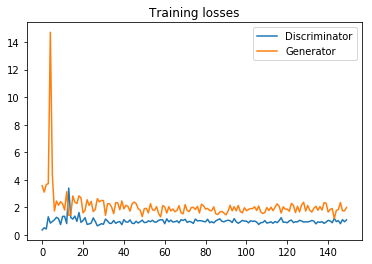

In [84]:
fig,ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0],label='Discriminator')
plt.plot(losses.T[1],label='Generator')
plt.title('Training losses')
plt.legend()

In [85]:
def view_samples(epoch,samples):
    fig,axes = plt.subplots(nrows=4,ncols=4,sharex=True,sharey=True,figsize=(7,7))
    for ax,img in zip(axes.flatten(),samples[epoch][0]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)),cmap='Greys_r')
    return fig,axes

In [86]:
with open('generator_samples.pkl','rb') as f:
    samples = p.load(f)

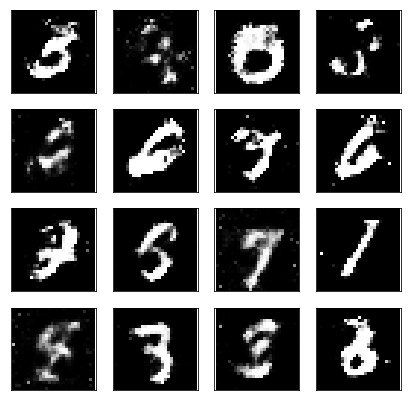

In [87]:
_ = view_samples(-1,samples)
#print(np.array(samples).T[1])

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


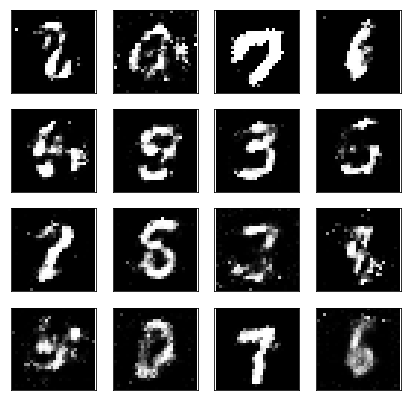

In [88]:
with tf.Session() as sess:
    saver.restore(sess,tf.train.latest_checkpoint('checkpoints'))
    sample_z = np.random.uniform(-1,1,(16,z_size))
    sample_g = sess.run(generator(z_inputs,input_size,reuse=True),feed_dict={z_inputs:sample_z})
_ = view_samples(0,[sample_g])